In [1]:
import numpy
import gzip
import numpy as np
import pandas as pd
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
import warnings
import shutil
import xarray
from datetime import date
warnings.filterwarnings('ignore')
import pycountry
import json

sys.path.append(os.path.expanduser("~")+'/CEUAS/CEUAS/public/cds-backend/code/')
import cds_eua4 as eua
sys.path.append(os.path.expanduser("~")+'/uvpy/')
import uvfunctions as uvf
import uvplot as uvp
import uvtests as uvt

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['figure.figsize'] = (20, 10)
font = {'size'   : 20}
matplotlib.rc('font', **font)

from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import Image

no config found


# wind trends

In [2]:
import pickle
sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools
def show_trend_map(file,label, c_bar, multiplier = 1, c_bar_red_top = True):
    plev = file.split('_')[-5]
    sdate = file.split('_')[-4]
    edate = file.split('_')[-3]
    good_results = {}
    good_results['lat'] = []
    good_results['lon'] = []
    good_results['st'] = []
    good_results['at'] = []
    good_results['label'] = []
    
    if c_bar_red_top:
        cs = 'RdBu_r'
    else:
        cs = 'RdBu'
    
    results = pickle.load(open(file, 'rb'))
    for i in results:
        badflag = 0
        for j in i:
            try:
                if np.isnan(j):
                    badflag = 1
            except:
                pass
        if badflag == 0:
            good_results['lat'].append(i[1])
            good_results['lon'].append(i[2])
            good_results['st'].append(i[3][0])
            good_results['at'].append(i[4][0])
            good_results['label'].append(i[0].split('/')[-1].split('_')[0])
    da = pd.DataFrame.from_dict(good_results)
    
    cmin = np.min([np.min(da['at']), np.min(da['st'])])
    cmax = np.max([np.max(da['at']), np.max(da['st'])])
    if np.abs(cmin) >= np.abs(cmax):
        cmax = -1 * cmin
    else:
        cmin = -1 * cmax
    
    statnum = len(da)
    a = rasotools.plot._helpers.cost(np.asarray(da.lon), np.asarray(da.lat), np.asarray(da.st))
    cost = np.sum(a)/len(a)
    fig1 = uvp.world_map_mpl(da.lat, da.lon, da['st'], label + ' trend unadjusted \n '+str(plev)+'_'+sdate+'_'+edate+' \n heterogeneity cost: ' + str(cost), inp_vmin=-2, inp_vmax=2, cbar_label='v [m/s]/10a')
    # fig1 = uvp.world_map_plot(da.st, da.lat, da.lon, da.label, label + ' trend unadjusted <br> '+str(plev)+'_'+sdate+'_'+edate+'<br> stats: '+ str(statnum) +' <br> heterogeneity cost: ' + str(cost), show = False, mid = True, cbar_title=c_bar, cs=cs, icmax=cmax, icmin=cmin) # 

    # img = fig1.to_image(format="png")
    # display(Image(img) )

    a = rasotools.plot._helpers.cost(np.asarray(da.lon), np.asarray(da.lat), np.asarray(da['at']))
    cost = np.sum(a)/len(a)
    fig1 = uvp.world_map_mpl(da.lat, da.lon, da['at'], label + ' trend adjusted \n '+str(plev)+'_'+sdate+'_'+edate+' \n heterogeneity cost: ' + str(cost), inp_vmin=-2, inp_vmax=2, cbar_label='v [m/s]/10a')
    # fig2 = uvp.world_map_plot(da['at'], da.lat, da.lon, da.label, label + ' trend adjusted <br> '+str(plev)+'_'+sdate+'_'+edate+'<br> stats: '+ str(statnum) +' <br> heterogeneity cost: ' + str(cost), show = False, mid = True, cbar_title=c_bar, cs=cs, icmax=cmax, icmin=cmin) # 


    # img = fig2.to_image(format="png")
    # display(Image(img))
    return da


In [3]:
import pickle
sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools
def show_trend_diff_map(file,label, c_bar, multiplier = 1, c_bar_red_top = True):
    plev = file.split('_')[-5]
    sdate = file.split('_')[-4]
    edate = file.split('_')[-3]
    good_results = {}
    good_results['lat'] = []
    good_results['lon'] = []
    good_results['st'] = []
    good_results['at'] = []
    good_results['label'] = []
    
    if c_bar_red_top:
        cs = 'RdBu_r'
    else:
        cs = 'RdBu'
    
    results = pickle.load(open(file, 'rb'))
    for i in results:
        badflag = 0
        for j in i:
            try:
                if np.isnan(j):
                    badflag = 1
            except:
                pass
        if badflag == 0:
            good_results['lat'].append(i[1])
            good_results['lon'].append(i[2])
            good_results['st'].append(i[3][0])
            good_results['at'].append(i[4][0])
            good_results['label'].append(i[0].split('/')[-1].split('_')[0])
    da = pd.DataFrame.from_dict(good_results)
    da['diff'] = da['at'] - da['st']
    statnum = len(da)

    a = rasotools.plot._helpers.cost(np.asarray(da.lon), np.asarray(da.lat), np.asarray(da['diff']))
    cost = np.sum(a)/len(a)
    fig1 = uvp.world_map_mpl(da.lat, da.lon, da['diff'], label + ' trend adjusted - unadjusted \n '+str(plev)+'_'+sdate+'_'+edate+' \n heterogeneity cost: ' + str(cost),)# inp_vmin=-0.1, inp_vmax=0.1)
    # fig1 = uvp.world_map_plot(da['diff'], da.lat, da.lon, da.label, label + ' trend adjusted - unadjusted <br> '+str(plev)+'_'+sdate+'_'+edate+' <br> stats: '+ str(statnum) +'  <br> heterogeneity cost: ' + str(cost), show = False, mid = True, cbar_title=c_bar, cs=cs) # 

    # img = fig1.to_image(format="png")
    # display(Image(img) )


In [4]:
# import pickle
# sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
# import rasotools
# def show_adj_map(file,label, c_bar, multiplier = 1, c_bar_red_top = True):
#     plev = file.split('_')[-5]
#     sdate = file.split('_')[-4]
#     edate = file.split('_')[-3]
#     good_results = {}
#     good_results['lat'] = []
#     good_results['lon'] = []
#     good_results['st'] = []
#     good_results['at'] = []
#     good_results['label'] = []
    
#     if c_bar_red_top:
#         cs = 'RdBu_r'
#     else:
#         cs = 'RdBu'
    
#     results = pickle.load(open(file, 'rb'))
#     for i in results:
#         badflag = 0
#         for j in i:
#             try:
#                 if np.isnan(j):
#                     badflag += 1
#             except:
#                 pass
#         if badflag < 2:
#             good_results['lat'].append(i[1])
#             good_results['lon'].append(i[2])
#             good_results['st'].append(i[3][0])
#             good_results['at'].append(i[4][0])
#             good_results['label'].append(i[0].split('/')[-1].split('_')[0])
#     da = pd.DataFrame.from_dict(good_results)
#     statnum = len(da)

#     a = rasotools.plot._helpers.cost(np.asarray(da.lon), np.asarray(da.lat), np.asarray(da['st']))
#     cost = np.sum(a)/len(a)
#     fig1 = uvp.world_map_plot(da['st'], da.lat, da.lon, da.label, label + ' <br> '+str(plev)+'_'+sdate+'_'+edate+' <br> heterogeneity cost: ' + str(cost), show = False, mid = True, cbar_title=c_bar, cs=cs) # 

#     img = fig1.to_image(format="png")
#     display(Image(img) )

In [5]:
# def seconds_to_datetime(seconds, ref="1900-01-01"):
#     """from seconds to datetime64"""
#     seconds = np.asarray(seconds)
#     return pd.to_datetime(seconds, unit="s", origin=ref)


# df_dict = {}
# with h5py.File('/mnt/users/scratch/leo/scratch/converted_v13/long/0-20000-0-72764_CEUAS_merged_v1.nc', "r") as file:
#         rts = file["recordindices"]["recordtimestamp"][:]
#         plevs = [85000]

#         idx_d = {}
#         var_d = {'wind_dir': "140"}

#         for j in var_d:
#             idx_d[j] = file["recordindices"][var_d[j]][:]

#         masks = {}
#         for j in idx_d:
#             masks[j] = file["observations_table"]["z_coordinate"][
#                 idx_d[j][0]:idx_d[j][-1]
#             ]
#             masks[j] = np.isin(masks[j], plevs)
#         mask = masks["wind_dir"]
#         t_idx = idx_d["wind_dir"]

#         df_dict["observation_value"] = list(
#             file["observations_table"]["observation_value"][t_idx[0]:t_idx[-1]][
#                 mask
#             ]
#         )
#         df_dict["z_coordinate"] = list(
#             file["observations_table"]["z_coordinate"][t_idx[0]:t_idx[-1]][mask]
#         )
#         df_dict["date_time"] = seconds_to_datetime(
#             list(
#                 file["observations_table"]["date_time"][t_idx[0]:t_idx[-1]][mask]
#             )
#         )
#         df_dict["latitude"] = list(
#             file["observations_table"]["latitude"][t_idx[0]:t_idx[-1]][mask]
#         )
#         df_dict["longitude"] = list(
#             file["observations_table"]["longitude"][t_idx[0]:t_idx[-1]][mask]
#         )
#         df_dict["wind_bias_estimate"] = list(
#             file["advanced_homogenisation"]["wind_bias_estimate"][
#                 t_idx[0]:t_idx[-1]
#             ][mask]
#         )
#         df_dict["fg"] = list(
#             file["era5fb"]["fg_depar@body"][
#                 t_idx[0]:t_idx[-1]
#             ][mask]
#         )
#         df_dict["bc"] = list(
#             file["era5fb"]["biascorr@body"][
#                 t_idx[0]:t_idx[-1]
#             ][mask]
#         )
#         # print('reading data: ', time.time()-t0, ' s')
#         # t1 = time.time()
#         temp = pd.DataFrame.from_dict(df_dict)

In [6]:
# with h5py.File('/mnt/users/scratch/leo/scratch/converted_v13/long/0-20000-0-72764_CEUAS_merged_v1.nc', "r") as file:
#     display(file["era5fb"].keys())

In [7]:
# temp

In [8]:
# temp = temp[temp.date_time.dt.year < 1950]

In [9]:
# plt.figure(figsize = (16,9))

# plt.plot(temp.date_time, temp.observation_value, color = "red", linewidth = 3.5, alpha = 0.6, ls= ':', label = "WD")
# # plt.plot(temp.date_time, temp.wind_bias_estimate, color = "blue", linestyle = "--", label = "wind bias estimate")
# # plt.plot(temp.date_time, np.remainder(temp.observation_value - temp.wind_bias_estimate, 360), color = "green", alpha = 0.3, label = " - adjusted WD")
# plt.plot(temp.date_time, np.remainder(temp.observation_value + temp.wind_bias_estimate, 360), color = "green", alpha = 0.3, label = " + adjusted WD")

# #Add title
# plt.title("Wind Direction 72764", fontsize = 16, pad = 20)

# #Add legend (you need to define labels for your plots)
# plt.legend(loc='center') # loc default is "best"
# plt.grid()
# plt.show()

## eastward windspeed: u

In [10]:
# files = glob.glob('polyfit_trends_u_7*20230817.p')
# print(files)
# label = 'eastward component of wind'
# c_bar = 'u [m/s]/10a'
# for i in files:
#     show_trend_map(i, label, c_bar, c_bar_red_top=True)

In [11]:
# files = glob.glob('polyfit_trends_u_7*20230817.p')
# print(files)
# label = 'eastward component of wind'
# c_bar = 'u [m/s]/10a'
# for i in files:
#     show_trend_diff_map(i, label, c_bar, c_bar_red_top=True)

## northward windspeed: v

In [12]:
file = './polifit_trends/polyfit_trends_v_700hPa_1940-01-01_1959-12-31_Trend_20230824_2_sub.p'
plev = file.split('_')[-5]
sdate = file.split('_')[-4]
edate = file.split('_')[-3]
good_results = {}
good_results['lat'] = []
good_results['lon'] = []
good_results['st'] = []
good_results['at'] = []
good_results['label'] = []

results = pickle.load(open(file, 'rb'))
for i in results:
    badflag = 0
    for j in i:
        try:
            if np.isnan(j):
                badflag = 1
        except:
            pass
    if badflag == 0:
        good_results['lat'].append(i[1])
        good_results['lon'].append(i[2])
        good_results['st'].append(i[3][0])
        good_results['at'].append(i[4][0])
        good_results['label'].append(i[0].split('/')[-1].split('_')[0])
da = pd.DataFrame.from_dict(good_results)

In [13]:
da.sort_values(by='at')[:15]

,lat,lon,st,at,label
2,37.500000,-77.330002,-1.948687,-1.187373,0-20000-0-72401
111,36.200001,-95.900002,-1.659179,-1.106606,0-20000-0-72356
47,33.400002,-104.529999,-1.380182,-0.974956,0-23001-2-orph0665
112,39.049999,-84.669998,-1.866767,-0.926570,0-20000-0-72421
73,44.770000,-106.970001,-1.622764,-0.880618,0-23001-2-orph0609
68,44.470001,-73.150002,-2.421963,-0.782239,0-20000-0-72617
102,38.750000,-90.379997,-2.011326,-0.773065,0-20000-0-72434
114,44.029999,-103.050003,-1.850842,-0.684875,0-20001-0-72662
38,33.400002,-104.529999,-1.569618,-0.642620,0-20000-0-72268
106,35.230000,-101.699997,-1.343533,-0.627994,0-20000-0-72363


['./polifit_trends/polyfit_trends_v_700hPa_1940-01-01_1959-12-31_Trend_20230824_2_sub.p', './polifit_trends/polyfit_trends_v_700hPa_1958-01-01_1987-12-31_Trend_20230824_2_sub.p', './polifit_trends/polyfit_trends_v_700hPa_1973-01-01_2002-12-31_Trend_20230824_2_sub.p', './polifit_trends/polyfit_trends_v_700hPa_1993-01-01_2022-12-31_Trend_20230824_2_sub.p']


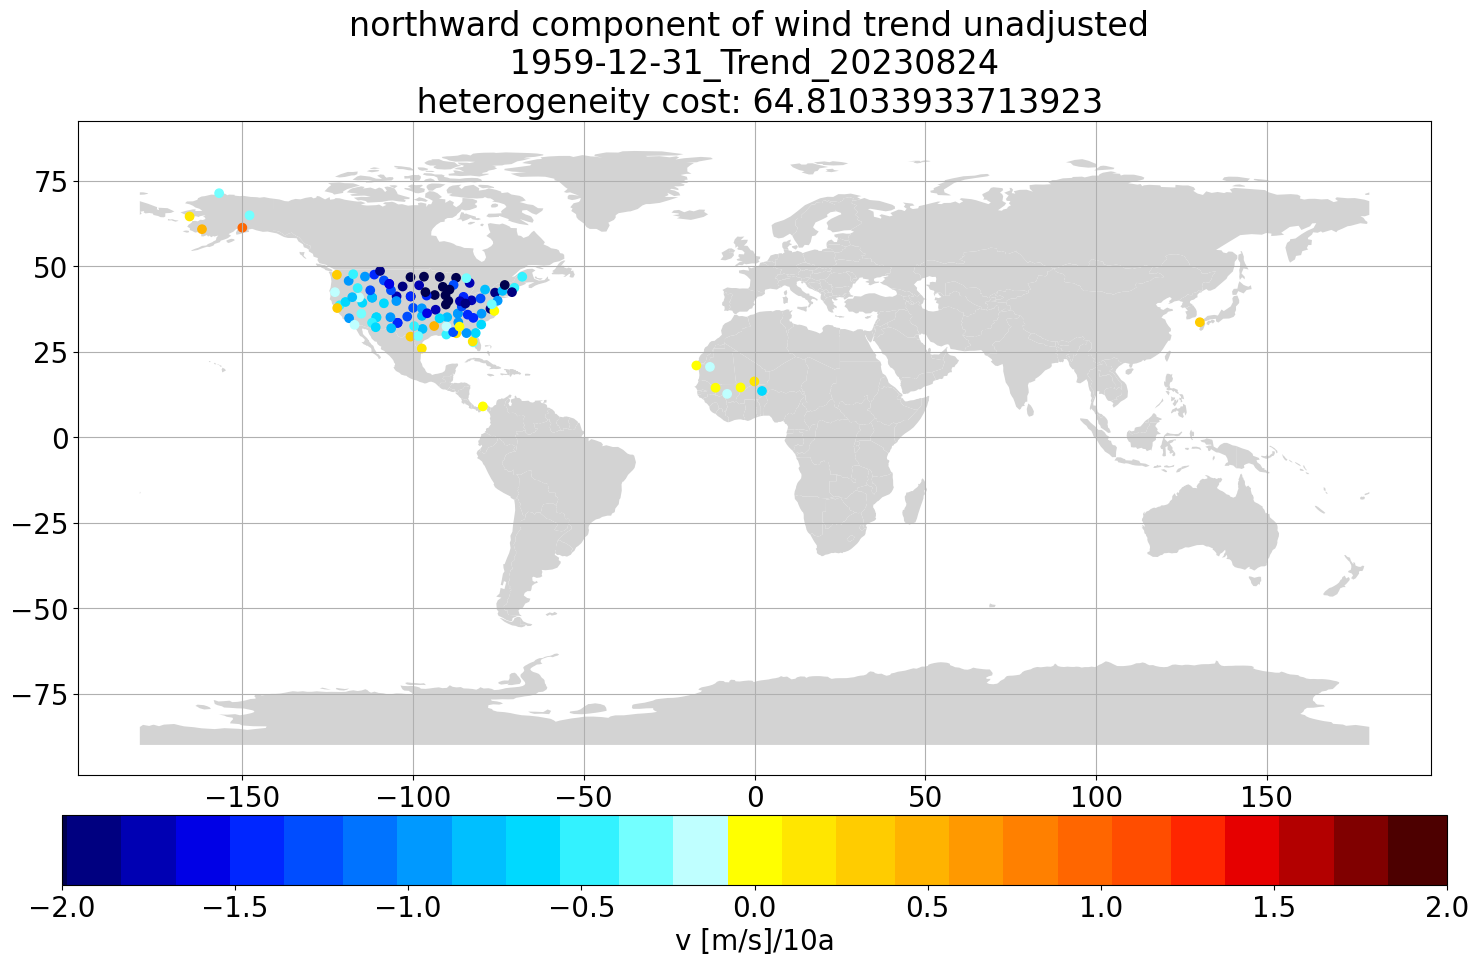

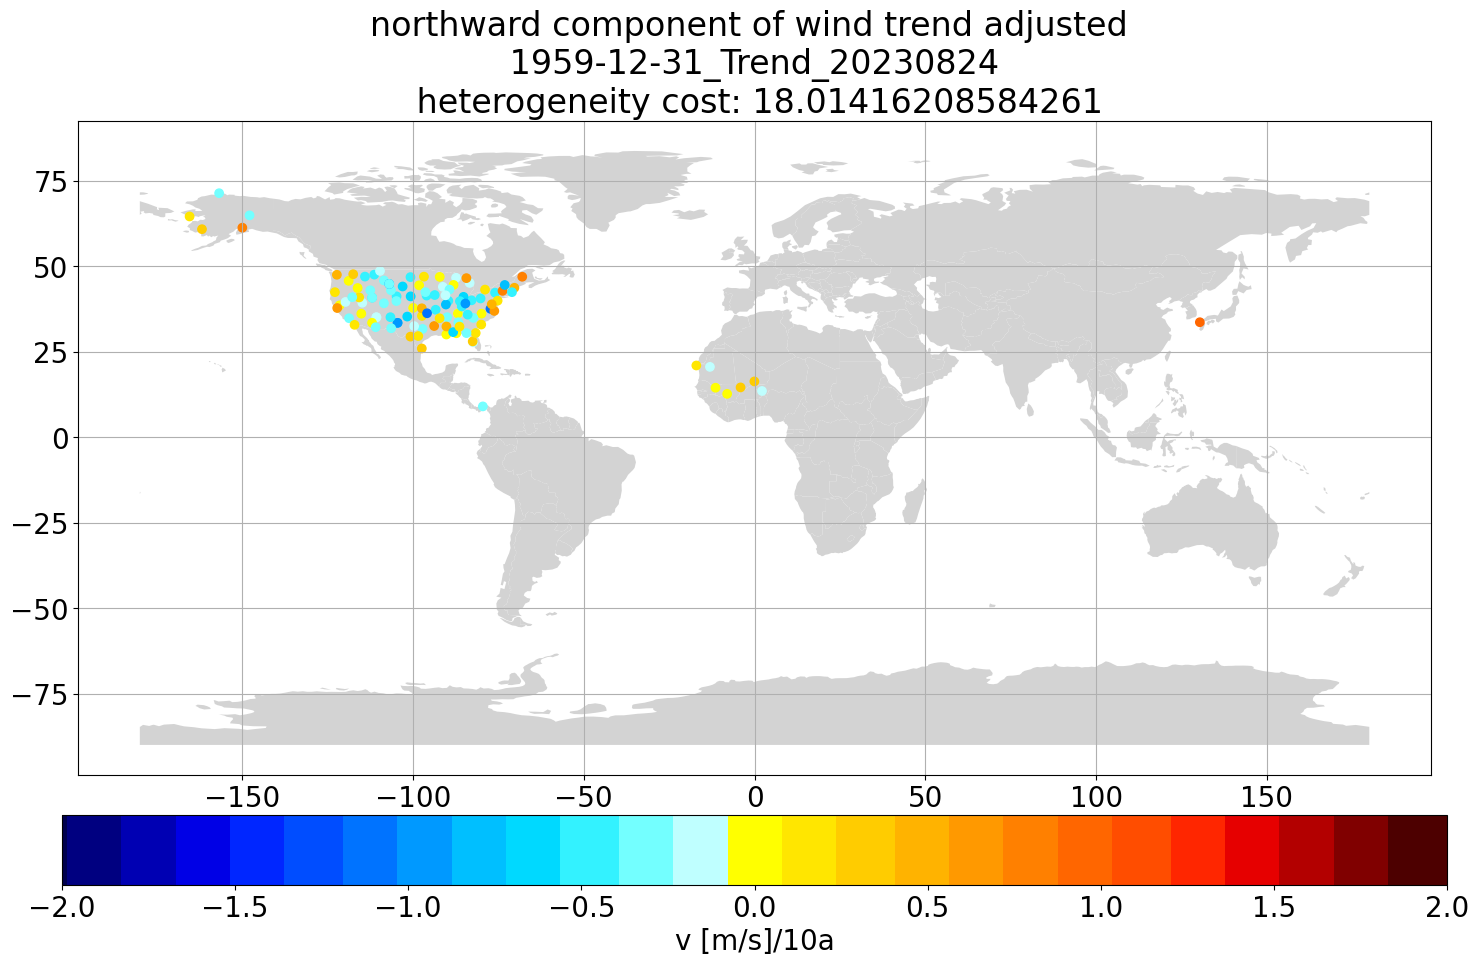

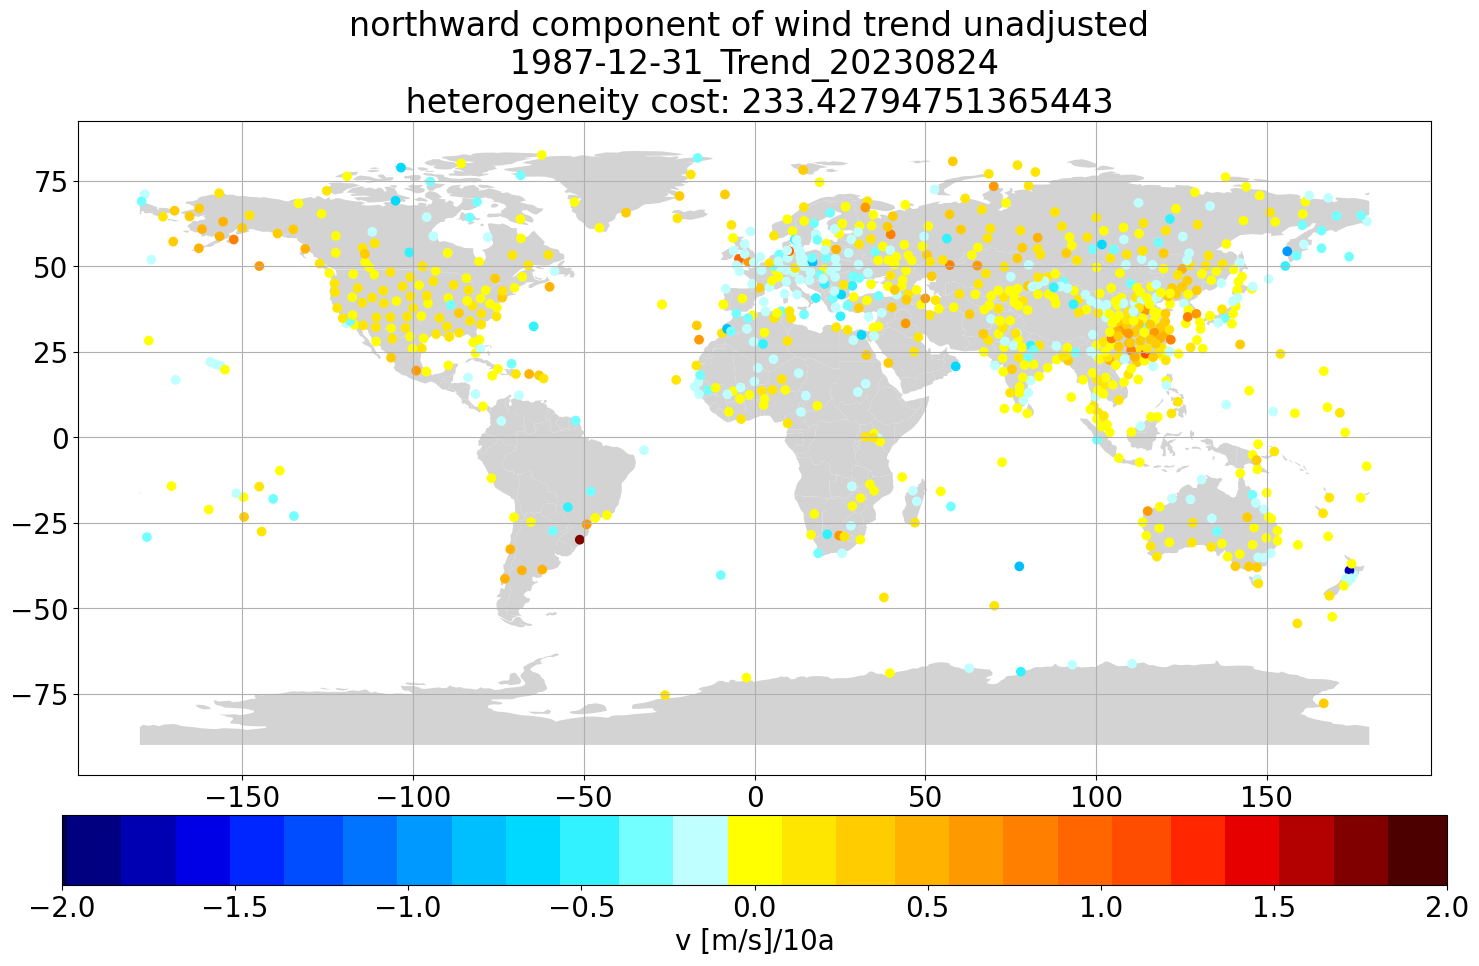

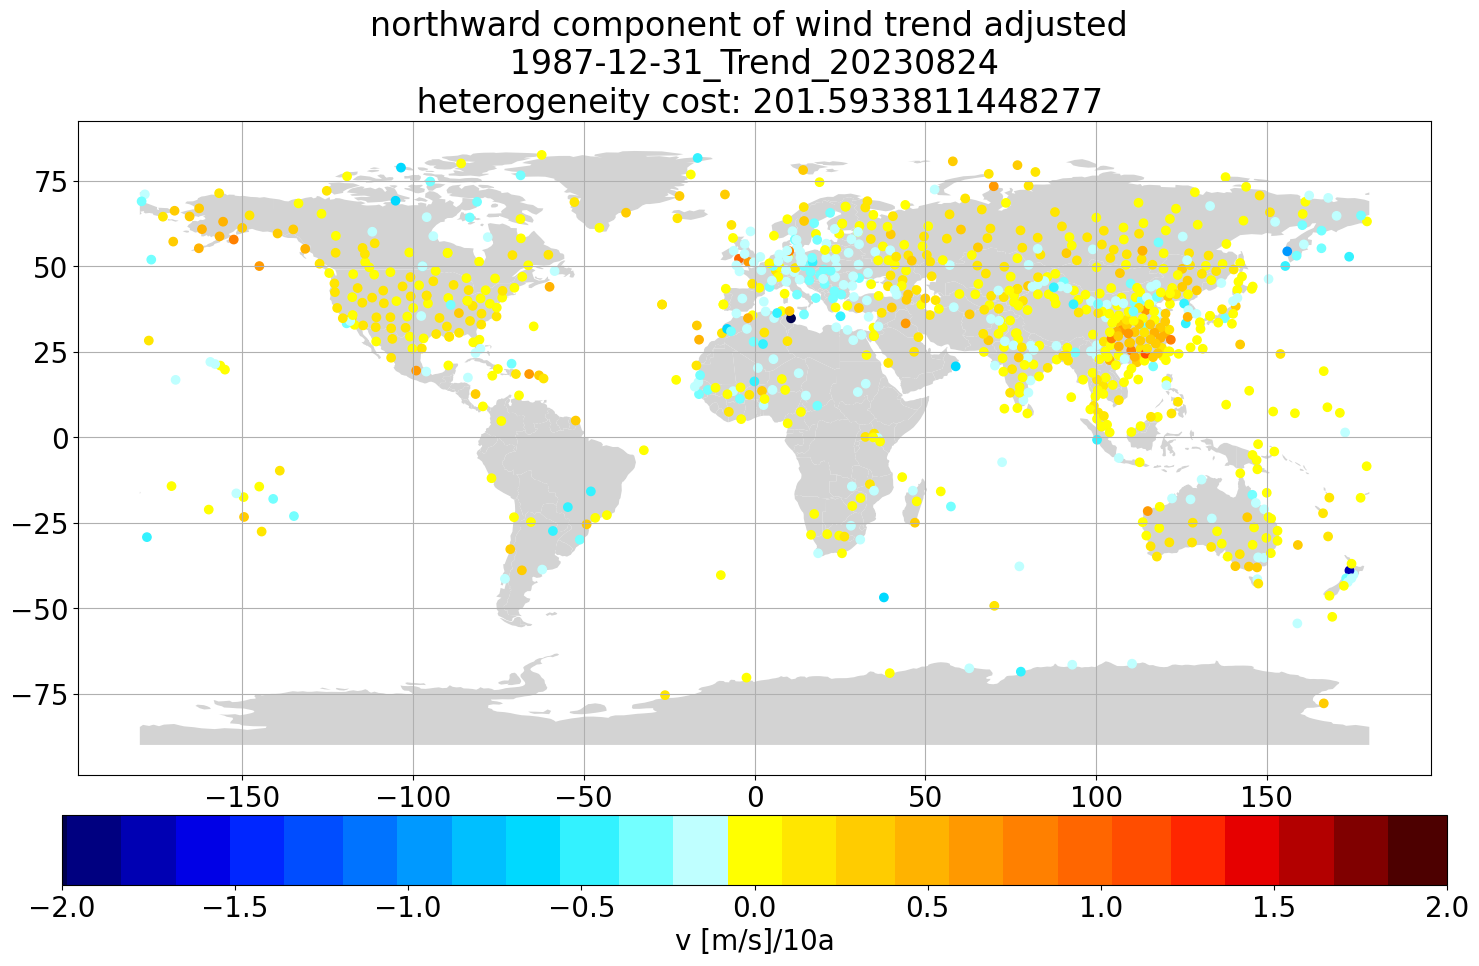

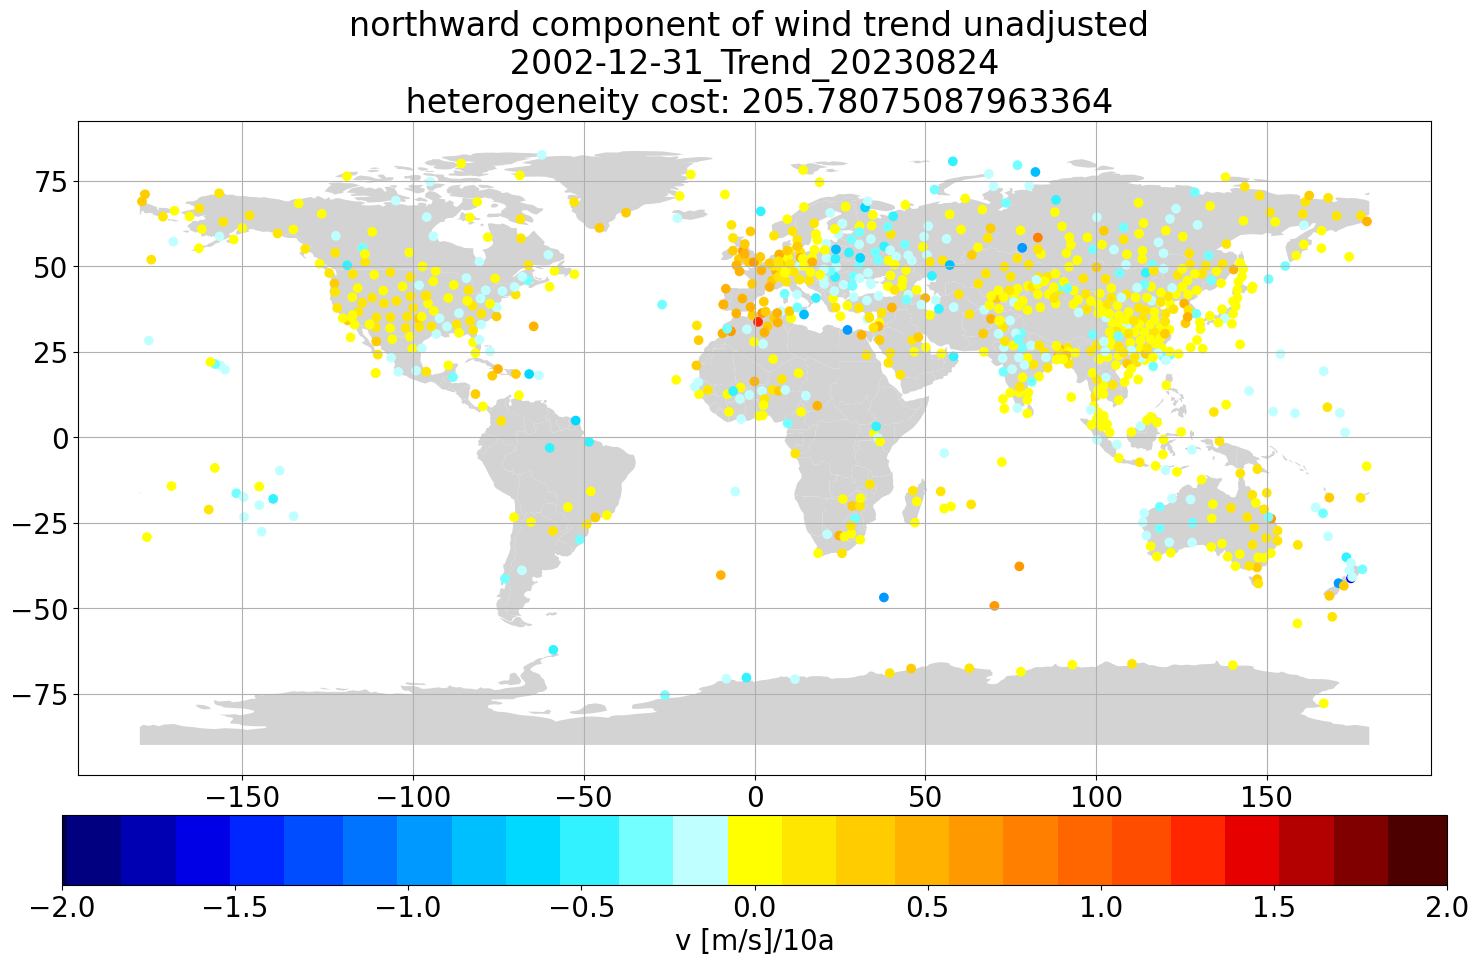

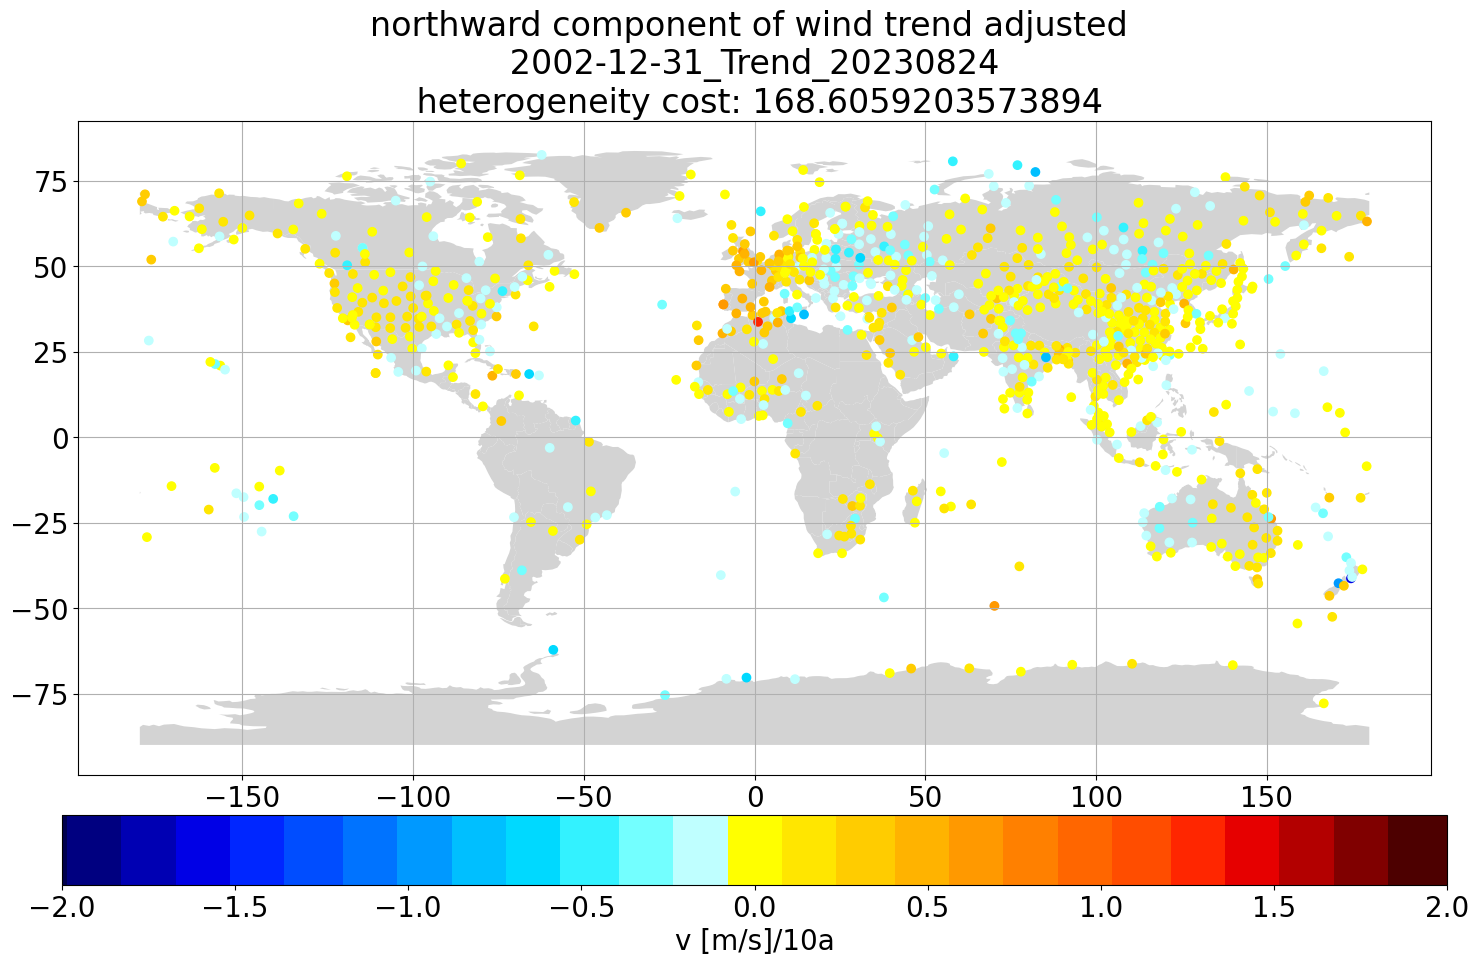

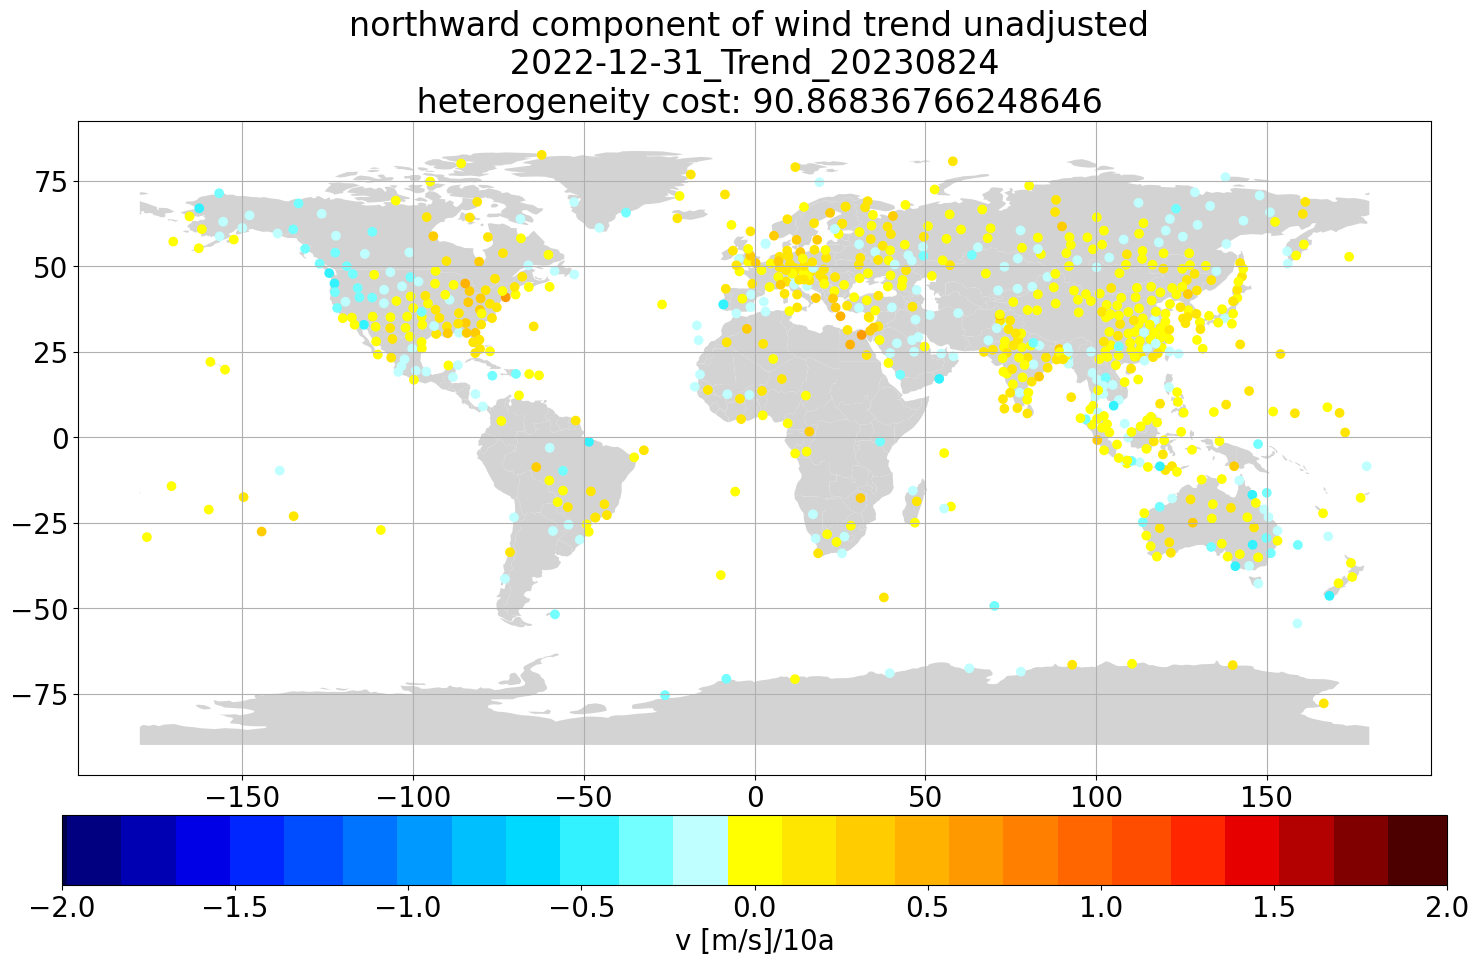

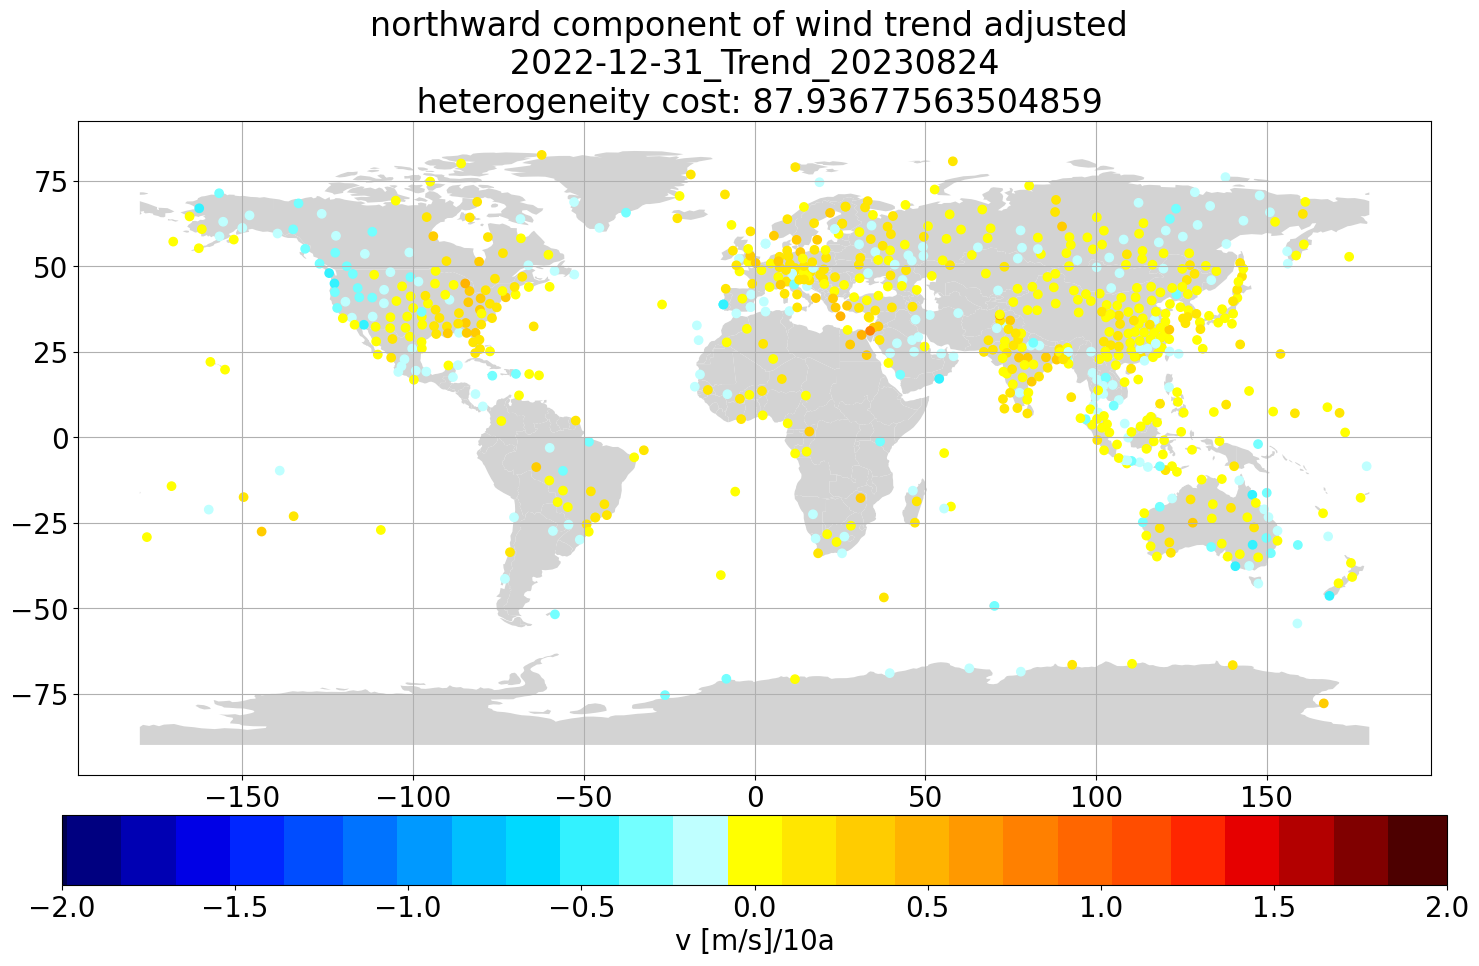

In [14]:
files = glob.glob('./polifit_trends/polyfit_trends_v_7*20230824_2_sub.p')
print(files)
label = 'northward component of wind'
c_bar = 'v [m/s]/10a'
for i in files:
    da = show_trend_map(i, label, c_bar, c_bar_red_top=True)

['./polifit_trends/polyfit_trends_v_700hPa_1940-01-01_1959-12-31_Trend_20230824_2_sub.p', './polifit_trends/polyfit_trends_v_700hPa_1958-01-01_1987-12-31_Trend_20230824_2_sub.p', './polifit_trends/polyfit_trends_v_700hPa_1973-01-01_2002-12-31_Trend_20230824_2_sub.p', './polifit_trends/polyfit_trends_v_700hPa_1993-01-01_2022-12-31_Trend_20230824_2_sub.p']


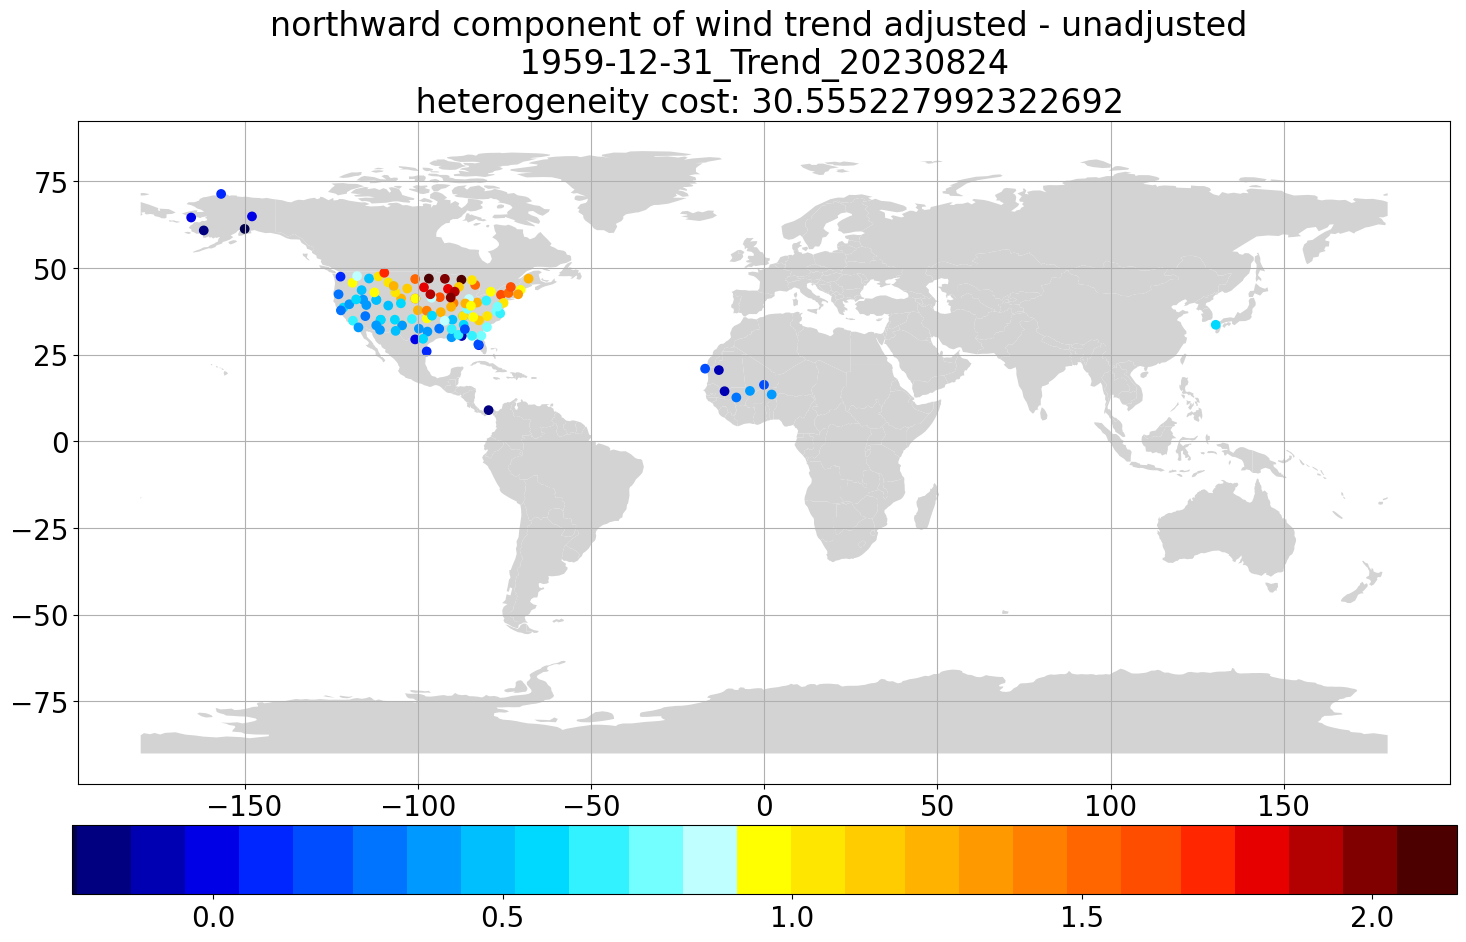

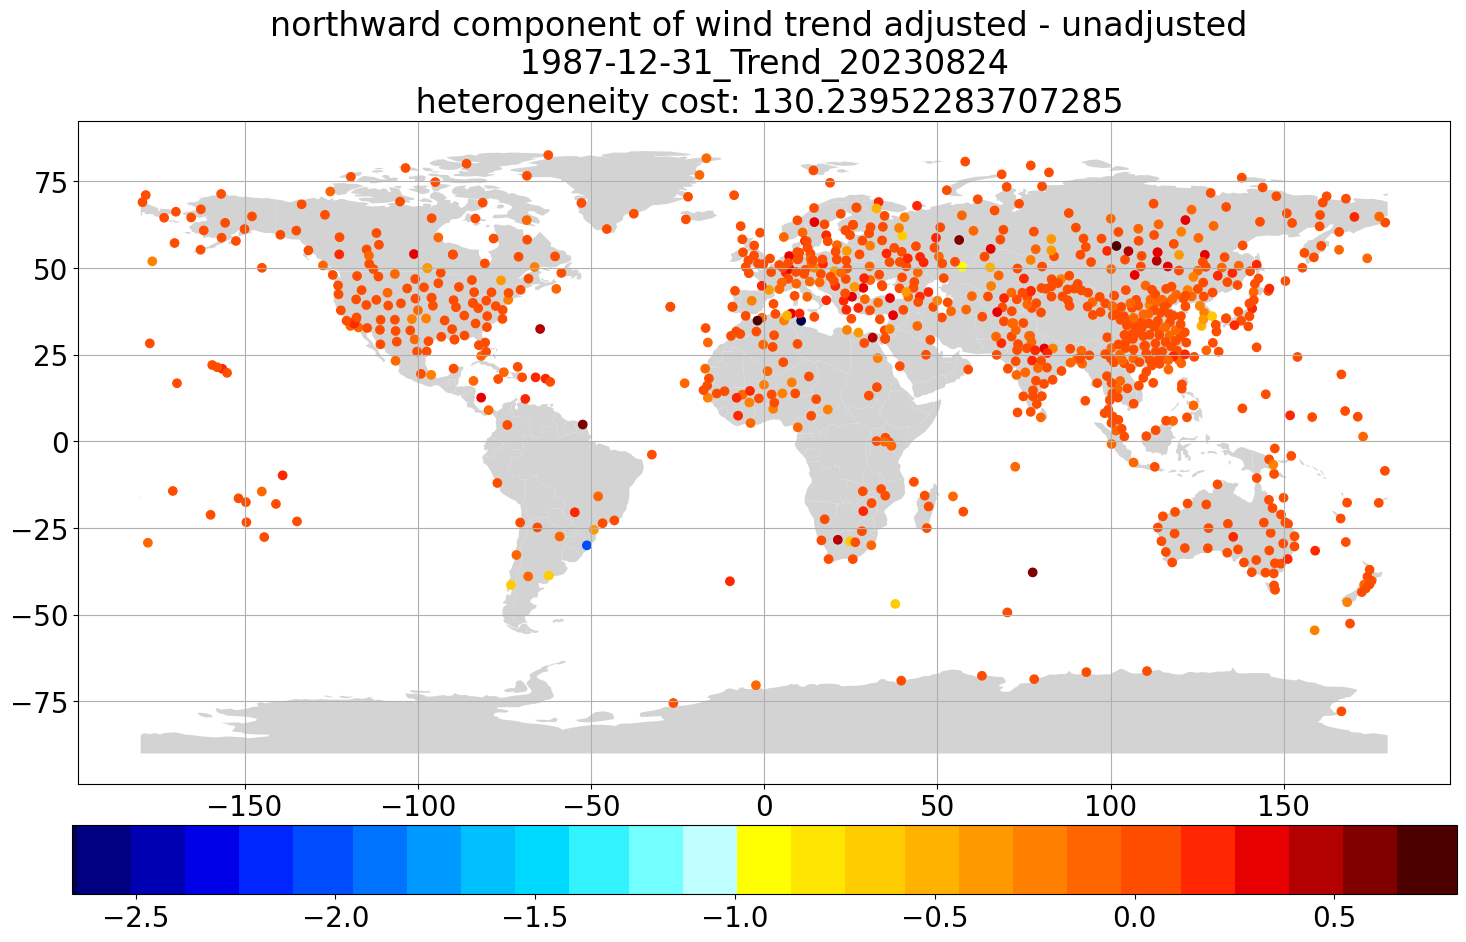

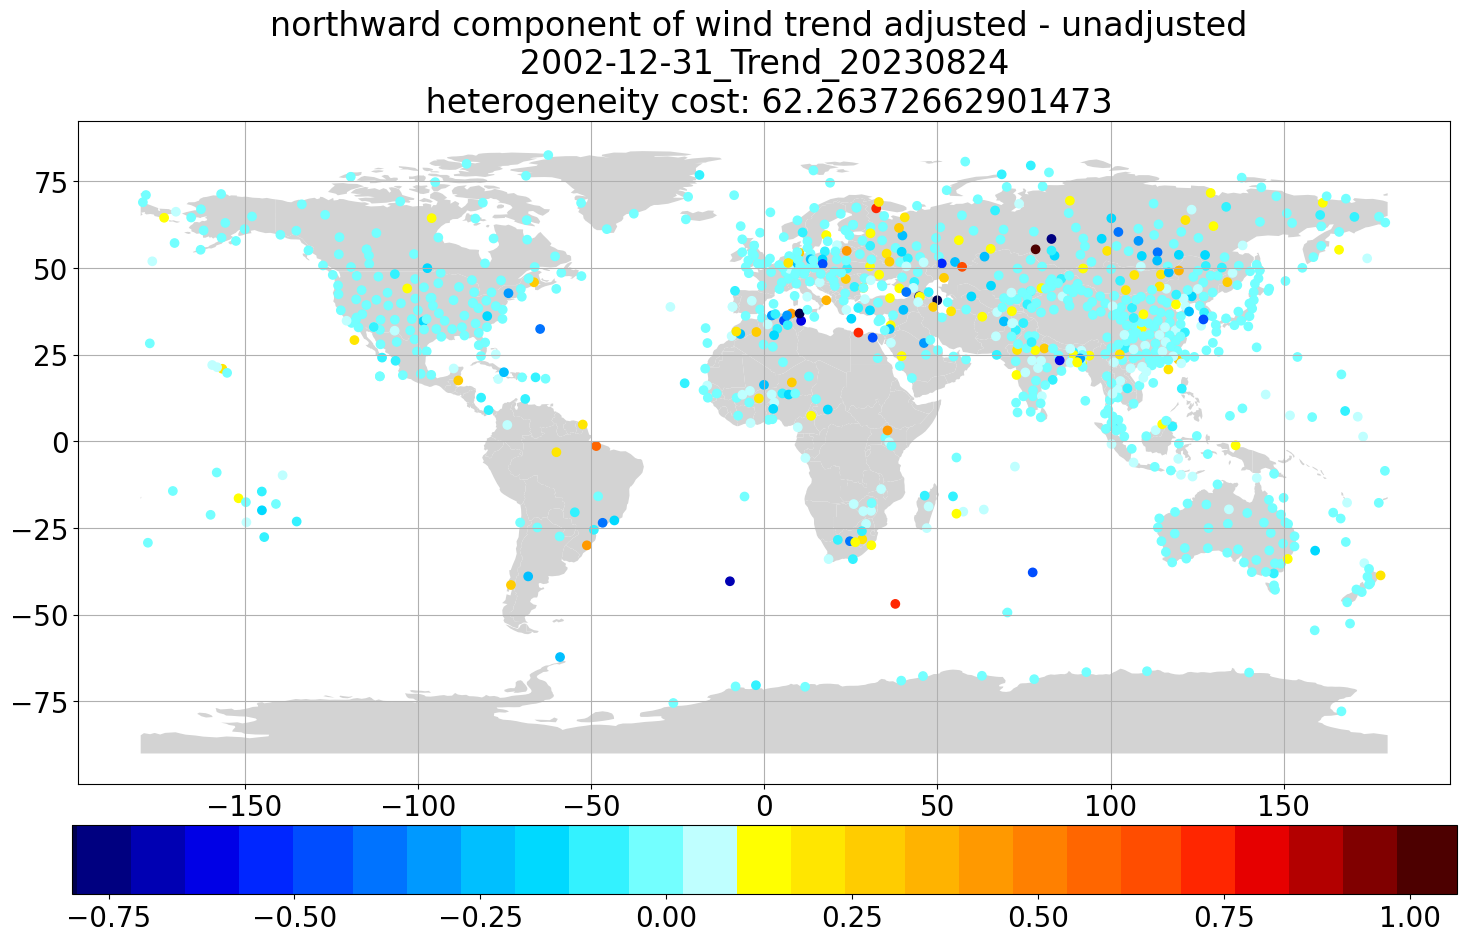

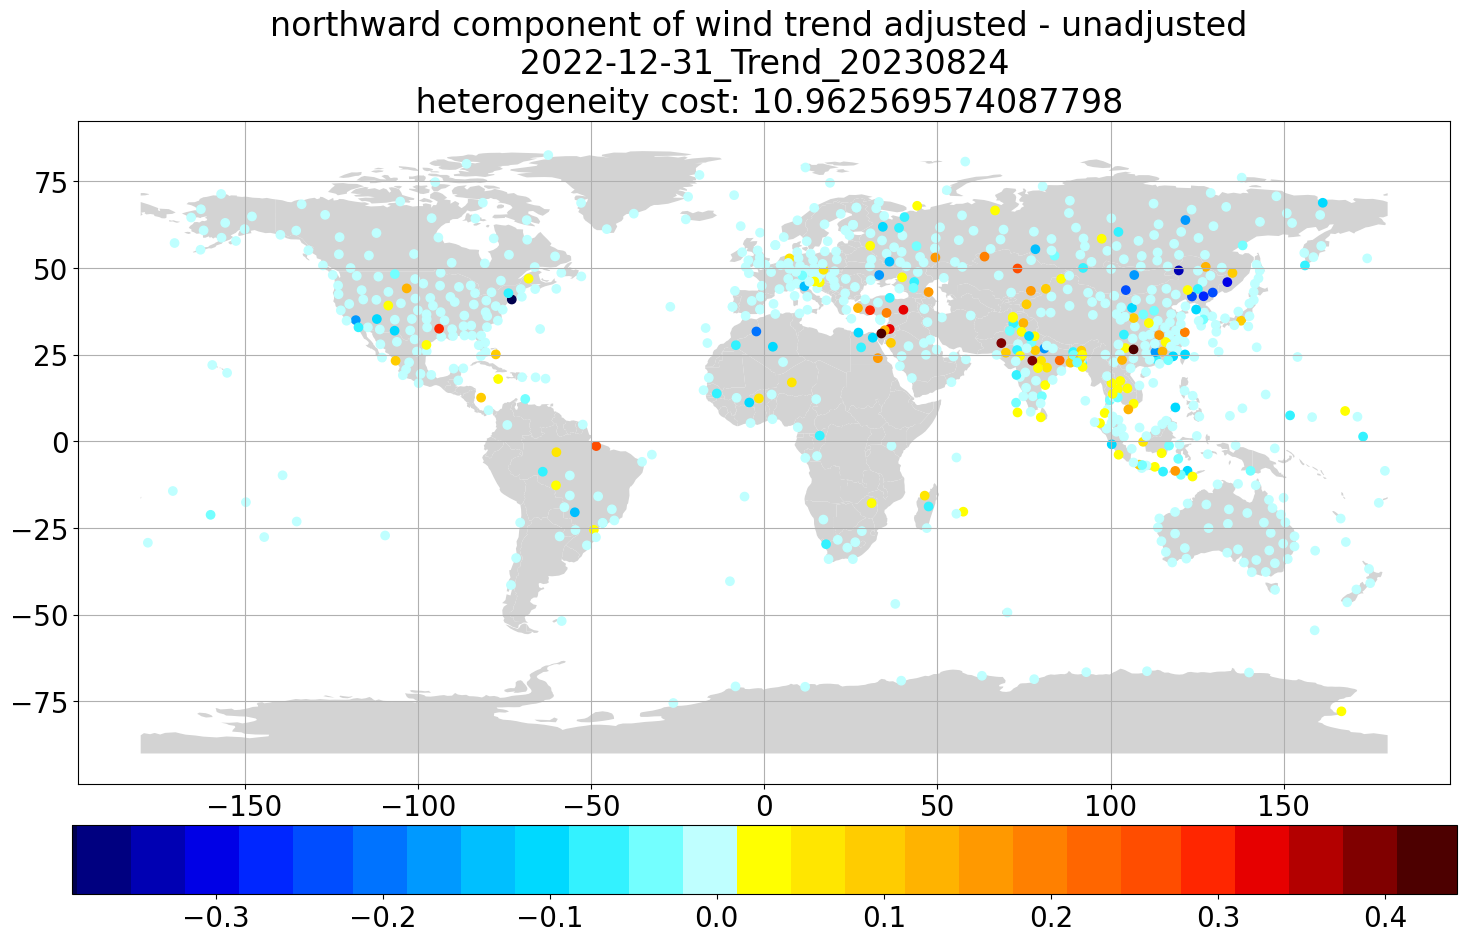

In [15]:
files = glob.glob('./polifit_trends/polyfit_trends_v_7*20230824_2_sub.p')
print(files)
label = 'northward component of wind'
c_bar = 'v [m/s]/10a'
for i in files:
    show_trend_diff_map(i, label, c_bar, c_bar_red_top=True)

## wdir adj:

In [16]:
# files = glob.glob('wd_adj_*20230817.p')
# print(files)
# label = 'wind direction adjustments'
# c_bar = 'wd [°]/10a'
# for i in files:
#     show_adj_map(i, label, c_bar, c_bar_red_top=True)

## wind speed: ws

In [17]:
# files = glob.glob('polyfit_trends_ws_7*20230817.p')
# print(files)
# label = 'wind speed trend unadjusted'
# c_bar = 'ws [m/s]/10a'
# for i in files:
#     show_adj_map(i, label, c_bar, c_bar_red_top=True)

In [18]:
# files = glob.glob('polyfit_trends_ws_*20230817.p')
# print(files)
# label = 'wind speed adjusted - unadjusted'
# c_bar = 'ws [m/s]/10a'
# for i in files:
#     show_trend_diff_map(i, label, c_bar, c_bar_red_top=True)

## wind direction: wd

In [19]:
# files = glob.glob('polyfit_trends_wd_7*20230817.p')
# print(files)
# label = 'wind direction'
# c_bar = 'wd [°]/10a'
# for i in files:
#     show_trend_map(i, label, c_bar, c_bar_red_top=True)

In [20]:
# files = glob.glob('polyfit_trends_wd_7*20230817.p')
# print(files)
# label = 'wind direction adjusted - unadjusted'
# c_bar = 'wd [°]/10a'
# for i in files:
#     show_trend_diff_map(i, label, c_bar, c_bar_red_top=True)